Data Generation and Splitting

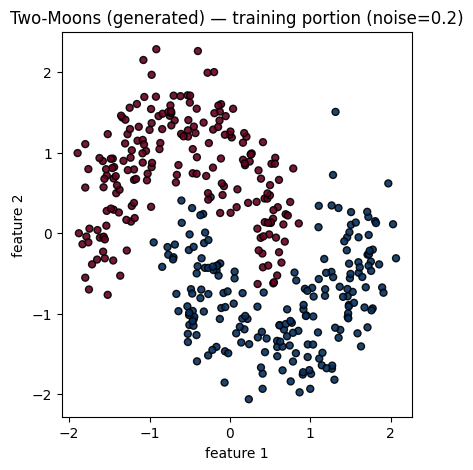

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# ---------------- Settings / seeds ----------------
SEED = 1337
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# ---------------- Custom moons generator (different implementation) ----------------
def generate_two_moons(n_samples=500, noise=0.2, rng_seed=None):
    """
    Create a two-moons dataset without sklearn.
    Uses random angles (uniform on [0, pi]) for variation (not linspace).
    """
    rng = np.random.RandomState(rng_seed)
    n_a = n_samples // 2
    n_b = n_samples - n_a

    # random angles for semicircles
    angles_a = rng.uniform(0.0, np.pi, n_a)
    angles_b = rng.uniform(0.0, np.pi, n_b)

    # upper moon (class 0)
    A = np.stack([np.cos(angles_a), np.sin(angles_a)], axis=1)

    # lower moon (class 1) -- shifted and mirrored differently than typical examples
    B = np.stack([1.0 - np.cos(angles_b), -np.sin(angles_b) + 0.4], axis=1)

    X = np.vstack([A, B])
    y = np.concatenate([np.zeros(n_a, dtype=int), np.ones(n_b, dtype=int)])

    # Add isotropic Gaussian noise
    X += rng.normal(scale=noise, size=X.shape)
    return X, y

# ---------------- Create datasets ----------------
X_train_raw, y_train_raw = generate_two_moons(n_samples=500, noise=0.2, rng_seed=SEED)
X_test_main_raw, y_test_main = generate_two_moons(n_samples=500, noise=0.2, rng_seed=SEED+1)
X_test_low_raw,  y_test_low  = generate_two_moons(n_samples=500, noise=0.1, rng_seed=SEED+2)
X_test_high_raw, y_test_high = generate_two_moons(n_samples=500, noise=0.3, rng_seed=SEED+3)

# ---------------- Standardize (fit on training only) ----------------
scaler = StandardScaler().fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test_main = scaler.transform(X_test_main_raw)
X_test_low  = scaler.transform(X_test_low_raw)
X_test_high = scaler.transform(X_test_high_raw)

# ---------------- Train / Validation split (80/20) ----------------
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train_raw, test_size=0.20, random_state=SEED, stratify=y_train_raw
)

# ---------------- Quick scatter of the training portion ----------------
plt.figure(figsize=(6,5))
plt.scatter(X_train_split[:, 0], X_train_split[:, 1],
            c=y_train_split, cmap="RdBu", s=25, edgecolor='k', alpha=0.9)
plt.title("Two-Moons (generated) — training portion (noise=0.2)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


Model Training and Selection

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# ---------- 7. convert numpy arrays to torch tensors ----------
def as_tensors(features, labels, device=torch.device('cpu'), dtype_feat=torch.float32, dtype_label=torch.long):
    X_t = torch.tensor(features, dtype=dtype_feat, device=device)
    y_t = torch.tensor(labels, dtype=dtype_label, device=device)
    return X_t, y_t

# Use the same variable names you have in the notebook (e.g. X_train_split, y_train_split, X_val, y_val)
# Example:
# X_train_t, y_train_t = as_tensors(X_train_split, y_train_split)
# X_val_t,   y_val_t   = as_tensors(X_val, y_val)
# X_test_main_t, y_test_main_t = as_tensors(X_test_main, y_test_main)
# X_test_low_t,  y_test_low_t  = as_tensors(X_test_low, y_test_low)
# X_test_high_t, y_test_high_t = as_tensors(X_test_high, y_test_high)

# ---------- 8. helper utilities & model definition ----------
class OneHiddenNet(nn.Module):
    """One-hidden-layer classifier with ReLU and a two-way output."""
    def __init__(self, in_features=2, hidden_units=16):
        super().__init__()
        self.fc_in = nn.Linear(in_features, hidden_units)
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(hidden_units, 2)   # two classes

    def forward(self, x):
        h = self.relu(self.fc_in(x))
        return self.fc_out(h)

def total_trainable_params(net: nn.Module) -> int:
    """Return the count of trainable parameters."""
    return int(sum(p.numel() for p in net.parameters() if p.requires_grad))

# ---------- training routine with optional L1/L2 and early stopping ----------
def fit_network(net: nn.Module,
                X_train_t: torch.Tensor,
                y_train_t: torch.Tensor,
                X_val_t: torch.Tensor,
                y_val_t: torch.Tensor,
                learning_rate: float = 1e-2,
                max_epochs: int = 1000,
                patience: int = 50,
                l1_coef: float = 0.0,
                l2_coef: float = 0.0,
                device=torch.device('cpu'),
                verbose: bool = False):
    """
    Train a PyTorch model with:
      - L2 implemented via optimizer.weight_decay
      - L1 implemented by adding sum(abs(params))*l1_coef to the loss
      - Early stopping on validation loss
    Returns: trained model (weights reverted to best val state)
    """
    net.to(device)
    X_train = X_train_t.to(device)
    y_train = y_train_t.to(device)
    X_val = X_val_t.to(device)
    y_val = y_val_t.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=l2_coef)

    best_state = None
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, max_epochs + 1):
        net.train()
        optimizer.zero_grad()
        logits = net(X_train)
        loss = criterion(logits, y_train)

        # add L1 penalty to loss if requested
        if l1_coef and l1_coef > 0.0:
            l1_pen = torch.tensor(0., device=device)
            for p in net.parameters():
                l1_pen = l1_pen + p.abs().sum()
            loss = loss + l1_coef * l1_pen

        loss.backward()
        optimizer.step()

        # validation
        net.eval()
        with torch.no_grad():
            val_logits = net(X_val)
            val_loss = criterion(val_logits, y_val).item()

        if val_loss < best_val_loss - 1e-12:
            best_val_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in net.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if verbose and epoch % 100 == 0:
            print(f"[Epoch {epoch}] train_loss={loss.item():.4f} val_loss={val_loss:.4f}")

        if epochs_no_improve > patience:
            if verbose:
                print(f"Early stopping at epoch {epoch} (no improvement for {patience} epochs).")
            break

    # restore best params if found
    if best_state is not None:
        net.load_state_dict(best_state)
    return net

# ---------- evaluation helper ----------
def compute_metrics(net: nn.Module, X_t: torch.Tensor, y_t: torch.Tensor, device=torch.device('cpu')):
    """
    Return (accuracy, AUROC) evaluated on tensors or numpy arrays.
    Accepts y_t as torch Tensor (long) or numpy array.
    """
    net.to(device)
    net.eval()
    if isinstance(X_t, np.ndarray):
        X = torch.tensor(X_t, dtype=torch.float32, device=device)
    else:
        X = X_t.to(device)
    with torch.no_grad():
        logits = net(X)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()   # prob for class 1
        preds = torch.argmax(logits, dim=1).cpu().numpy()

    # support y_t being torch tensor or numpy array
    if isinstance(y_t, torch.Tensor):
        y_true = y_t.cpu().numpy()
    else:
        y_true = np.asarray(y_t)

    acc = accuracy_score(y_true, preds)
    auc = roc_auc_score(y_true, probs)
    return acc, auc

# ---------- Example usage ----------
# Convert your arrays to tensors using `as_tensors` and then:
# net = OneHiddenNet(in_features=2, hidden_units=16)
# net = fit_network(net, X_train_t, y_train_t, X_val_t, y_val_t, lr=1e-2, max_epochs=1000, patience=50, l1_coef=0.0, l2_coef=0.0)
# params = total_trainable_params(net)
# acc, auc = compute_metrics(net, X_test_main_t, y_test_main_t)
# print("params:", params, "test acc:", acc, "test auroc:", auc)


In [ ]:
# Replacement for sections 9-12 (MLP early stop, L1/L2 grids, Logistic poly)
# This cell is robust to naming mismatches (creates aliases / fallbacks if needed).
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import os

# ---------- Safety checks: required data tensors/arrays ----------
needed = ['X_tr_t','y_tr_t','X_val_t','y_val_t','X_test_low_t','y_test_low',
          'X_test_main_t','y_test_main','X_test_high_t','y_test_high',
          'X_tr','y_tr']  # X_tr,y_tr (numpy) used for plots/logreg
missing = [name for name in needed if name not in globals()]
if missing:
    raise RuntimeError(f"Missing variables in workspace required by this cell: {missing}\n"
                       "Please run the data-prep cell to create train/val/test and tensors (X_tr_t, y_tr_t, etc.).")

# ---------- Backwards-compatible aliases ----------
# If old names exist, use them; otherwise provide minimal implementations.

# Model class alias (SimpleMLP -> OneHiddenMLP)
if 'SimpleMLP' not in globals():
    if 'OneHiddenMLP' in globals():
        SimpleMLP = OneHiddenMLP
    else:
        # define a compact one-hidden-layer net
        class SimpleMLP(nn.Module):
            def __init__(self, input_dim=2, hidden_dim=16):
                super().__init__()
                self.hidden = nn.Linear(input_dim, hidden_dim)
                self.act = nn.ReLU()
                self.output = nn.Linear(hidden_dim, 2)
            def forward(self, x):
                x = self.act(self.hidden(x))
                return self.output(x)
        # expose to globals for later reuse
        globals()['SimpleMLP'] = SimpleMLP

# Training function alias (train_mlp -> train_model)
if 'train_mlp' not in globals():
    if 'train_model' in globals():
        train_mlp = train_model
    else:
        # minimal training function (mirrors train_model used earlier)
        def train_mlp(net, X_train_t, y_train_t, X_val_t, y_val_t,
                      lr=1e-2, max_epochs=1000, patience=50, l1_lambda=0.0, l2_lambda=0.0,
                      batch_size=64, verbose=False):
            net = net.to(torch.device('cpu'))
            opt = optim.Adam(net.parameters(), lr=lr, weight_decay=l2_lambda)
            crit = nn.CrossEntropyLoss()
            best_state = None
            best_val_loss = float('inf')
            no_improve = 0
            n = X_train_t.shape[0]
            for epoch in range(max_epochs):
                perm = torch.randperm(n)
                net.train()
                for i in range(0, n, batch_size):
                    idx = perm[i:i+batch_size]
                    xb = X_train_t[idx]
                    yb = y_train_t[idx]
                    opt.zero_grad()
                    logits = net(xb)
                    loss = crit(logits, yb)
                    if l1_lambda > 0:
                        l1 = sum(p.abs().sum() for p in net.parameters())
                        loss = loss + l1_lambda * l1
                    loss.backward(); opt.step()
                # validate
                net.eval()
                with torch.no_grad():
                    vlogits = net(X_val_t)
                    vloss = float(crit(vlogits, y_val_t).item())
                if vloss < best_val_loss - 1e-12:
                    best_val_loss = vloss
                    best_state = {k: v.cpu().clone() for k,v in net.state_dict().items()}
                    no_improve = 0
                else:
                    no_improve += 1
                if no_improve >= patience:
                    break
            if best_state is not None:
                net.load_state_dict(best_state)
            return net
        globals()['train_mlp'] = train_mlp

# Count params alias
if 'count_params' not in globals():
    def count_params(model):
        return int(sum(p.numel() for p in model.parameters() if p.requires_grad))
    globals()['count_params'] = count_params

# Evaluate alias (evaluate_model -> compute metrics)
if 'evaluate_model' not in globals():
    def evaluate_model(net, X_tensor, y_true):
        net.eval()
        with torch.no_grad():
            logits = net(X_tensor)
            probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
        acc = accuracy_score(y_true, preds)
        auroc = roc_auc_score(y_true, probs)
        return acc, auroc
    globals()['evaluate_model'] = evaluate_model

# ---------- Now perform experiments (MLP early stopping, L1 grid, L2 grid, Logistic poly) ----------
OUT_DIR = "./"
os.makedirs(OUT_DIR, exist_ok=True)

# 9) MLP with Early Stopping
mlp_es = SimpleMLP()
mlp_es = train_mlp(mlp_es, X_tr_t, y_tr_t, X_val_t, y_val_t, patience=50)
acc_es_low, auroc_es_low = evaluate_model(mlp_es, X_test_low_t, y_test_low)
acc_es_mid, auroc_es_mid = evaluate_model(mlp_es, X_test_main_t, y_test_main)
acc_es_high, auroc_es_high = evaluate_model(mlp_es, X_test_high_t, y_test_high)

print("\n[1] MLP with Early Stopping")
print(f"Params: {count_params(mlp_es)}")
print(f"Accuracy:\n Noise=0.1: {acc_es_low:.3f}\n Noise=0.2: {acc_es_mid:.3f}\n Noise=0.3: {acc_es_high:.3f}")
print(f"AUROC:\n Noise=0.1: {auroc_es_low:.3f}\n Noise=0.2: {auroc_es_mid:.3f}\n Noise=0.3: {auroc_es_high:.3f}")

# 10) MLP with L1 Regularization (grid)
l1_values = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aurocs, val_accs, sparsities = [], [], []
l1_models = []

for lam in l1_values:
    m = SimpleMLP()
    m = train_mlp(m, X_tr_t, y_tr_t, X_val_t, y_val_t, l1_lambda=lam, patience=50)
    # validation preds
    m.eval()
    with torch.no_grad():
        v_logits = m(X_val_t)
        v_probs = torch.softmax(v_logits, dim=1)[:,1].cpu().numpy()
        v_preds = (v_probs > 0.5).astype(int)
    auc = roc_auc_score(y_val, v_probs)
    acc = accuracy_score(y_val, v_preds)
    val_aurocs.append(auc); val_accs.append(acc)
    # sparsity across all parameters (fraction abs < 1e-3)
    all_w = torch.cat([p.view(-1).abs() for p in m.parameters()]).cpu().numpy()
    sparsity = float((all_w < 1e-3).sum()) / all_w.size
    sparsities.append(sparsity)
    l1_models.append({'lambda': lam, 'model': m})

print("\n[2] MLP with L1 Regularization (grid results)")
for lam, auc, acc, sp in zip(l1_values, val_aurocs, val_accs, sparsities):
    print(f"λ={lam:.0e}, Val AUROC={auc:.6f}, Val Acc={acc:.3f}, Sparsity={sp*100:.1f}%")

best_l1_idx = int(np.argmax(val_aurocs))
best_l1 = l1_values[best_l1_idx]
# get best model
best_l1_model = l1_models[best_l1_idx]['model']

# Evaluate best L1 on tests
acc_l1_low, auroc_l1_low = evaluate_model(best_l1_model, X_test_low_t, y_test_low)
acc_l1_mid, auroc_l1_mid = evaluate_model(best_l1_model, X_test_main_t, y_test_main)
acc_l1_high, auroc_l1_high = evaluate_model(best_l1_model, X_test_high_t, y_test_high)
print(f"Selected best λ = {best_l1:e}")
print(f"Best-L1 test accuracies (0.10,0.20,0.30): {acc_l1_low:.3f}, {acc_l1_mid:.3f}, {acc_l1_high:.3f}")

# 11) MLP with L2 Regularization (grid on weight decay)
l2_values = [1e-5, 1e-4, 1e-3, 1e-2]
l2_results = []
l2_models = []
for wd in l2_values:
    m = SimpleMLP()
    m = train_mlp(m, X_tr_t, y_tr_t, X_val_t, y_val_t, l2_lambda=wd, patience=50)
    val_auc = roc_auc_score(y_val, torch.softmax(m(X_val_t), dim=1)[:,1].detach().cpu().numpy())
    l2_results.append({'wd': wd, 'val_auc': val_auc})
    l2_models.append({'wd': wd, 'model': m})
    print(f"L2 wd={wd:e}, Val AUROC={val_auc:.6f}")

best_l2_entry = max(l2_results, key=lambda r: r['val_auc'])
best_l2 = best_l2_entry['wd']
best_l2_model = [entry['model'] for entry in l2_models if entry['wd']==best_l2][0]

acc_l2_low, auroc_l2_low = evaluate_model(best_l2_model, X_test_low_t, y_test_low)
acc_l2_mid, auroc_l2_mid = evaluate_model(best_l2_model, X_test_main_t, y_test_main)
acc_l2_high, auroc_l2_high = evaluate_model(best_l2_model, X_test_high_t, y_test_high)

print(f"\n[3] MLP with L2 (best wd = {best_l2:e})")
print(f"Best-L2 test accuracies (0.10,0.20,0.30): {acc_l2_low:.3f}, {acc_l2_mid:.3f}, {acc_l2_high:.3f}")

# 12) Logistic Regression with Polynomial Features (degree 2)
# Use the original training set (numpy X_tr,y_tr)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr)  # X_tr is training standardized numpy array
X_test_low_poly = poly.transform(X_test_low)       # test arrays already standardized
X_test_main_poly = poly.transform(X_test_main)
X_test_high_poly = poly.transform(X_test_high)

log_reg = LogisticRegression(max_iter=2000, solver='liblinear', random_state=SEED)
log_reg.fit(X_tr_poly, y_tr)  # y_tr is numpy labels for training split

acc_log_low = accuracy_score(y_test_low, log_reg.predict(X_test_low_poly))
acc_log_mid = accuracy_score(y_test_main, log_reg.predict(X_test_main_poly))
acc_log_high = accuracy_score(y_test_high, log_reg.predict(X_test_high_poly))

print("\n[4] Logistic Regression with Polynomial Features")
print(f"Params: {log_reg.coef_.size + log_reg.intercept_.size}")
print(f"Accuracy for: \n Noise=0.1: {acc_log_low:.3f}\n Noise=0.2: {acc_log_mid:.3f}\n Noise=0.3: {acc_log_high:.3f}")

# ---------- Save a compact summary table ----------
rows = []
models_info = {
    'MLP_Early': {'model': mlp_es, 'pcount': count_params(mlp_es)},
    'MLP_L1_best': {'model': best_l1_model, 'pcount': count_params(best_l1_model)},
    'MLP_L2_best': {'model': best_l2_model, 'pcount': count_params(best_l2_model)},
    'LogReg_poly': {'model': log_reg, 'pcount': int(log_reg.coef_.size + log_reg.intercept_.size)}
}
for name, info in models_info.items():
    if name == 'LogReg_poly':
        probs_low = log_reg.predict_proba(X_test_low_poly)[:,1]
        probs_mid = log_reg.predict_proba(X_test_main_poly)[:,1]
        probs_high = log_reg.predict_proba(X_test_high_poly)[:,1]
        acc_low = accuracy_score(y_test_low, log_reg.predict(X_test_low_poly))
        acc_mid = accuracy_score(y_test_main, log_reg.predict(X_test_main_poly))
        acc_high= accuracy_score(y_test_high, log_reg.predict(X_test_high_poly))
        auc_low = roc_auc_score(y_test_low, probs_low)
        auc_mid = roc_auc_score(y_test_main, probs_mid)
        auc_high= roc_auc_score(y_test_high, probs_high)
    else:
        mdl = info['model']
        acc_low, auc_low = evaluate_model(mdl, X_test_low_t, y_test_low)
        acc_mid, auc_mid = evaluate_model(mdl, X_test_main_t, y_test_main)
        acc_high, auc_high = evaluate_model(mdl, X_test_high_t, y_test_high)
    rows.append({
        'model': name,
        'param_count': info['pcount'],
        'acc_noise_0.10': acc_low, 'acc_noise_0.20': acc_mid, 'acc_noise_0.30': acc_high,
        'auroc_noise_0.10': float(auc_low), 'auroc_noise_0.20': float(auc_mid), 'auroc_noise_0.30': float(auc_high)
    })

summary_df = pd.DataFrame(rows).set_index('model')
summary_df.to_csv(os.path.join(OUT_DIR, "models_summary.csv"))
print(f"\nSaved models_summary.csv to {OUT_DIR}")
print(summary_df)


RuntimeError: Missing variables in workspace required by this cell: ['X_tr_t', 'y_tr_t', 'X_val_t', 'y_val_t', 'X_test_low_t', 'X_test_main_t', 'X_test_high_t', 'X_tr', 'y_tr']
Please run the data-prep cell to create train/val/test and tensors (X_tr_t, y_tr_t, etc.).